# Import Dependencies

In [1]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch import Tensor, full, triu,  stack,  tensor, stack,set_printoptions,where

set_printoptions(threshold=10000)
plt.style.use('dark_background')
plt.rcParams['font.family'] = 'Arial Unicode MS'
plt.rcParams['font.size'] = 15

def read_specific_lines(file_path: str, num_lines: int = 800000):
    try:
        with open(file_path, 'r') as file:
            lines = list(itertools.islice(file, num_lines))
            lines = [sentence.rstrip('\n') for sentence in lines]
        return lines
    except Exception as e:
        return f"Error reading file: {e}"


START_TOKEN = "<start>"
END_TOKEN = "<end>"
PAD_TOKEN = "<pad>"
english_data = "dataset/en.txt"
hindi_data = "dataset/hi.txt"


print("English Data")
english_lines = read_specific_lines(english_data)
print(english_lines[:10])
print("\nHindi Data")
hindi_lines = read_specific_lines(hindi_data)
print(hindi_lines[:10])

English Data
['In reply, Pakistan got off to a solid start.', 'The European Union has seven principal decision-making bodies, its institutions: the European Parliament, the European Council, the Council of the European Union, the European Commission, the Court of Justice of the European Union, the European Central Bank and the European Court of Auditors.', 'The Congress leader represents Sivaganga Lok Sabha segment from Tamil Nadu.', 'Prompt the user about connection attempts', 'Further, the Minister announced that Deposit Insurance and Credit Guarantee Corporation (DICGC) has been permitted to increase Deposit Insurance coverage to Rs.', 'Therefore, brothers, be more diligent to make your calling and election sure. For if you do these things, you will never stumble.', 'The review committee meeting chaired by the District Judges will be attended by Collectors, SPs, Superintendents of jails and Secretary of District Legal Services Authority.', 'Police is present on the spot.', 'Prime Mi

In [2]:
hind_vocabulary = [START_TOKEN,
                   'अ', 'आ', 'इ', 'ई', 'उ', 'ऊ', 'ए', 'ऐ', 'ओ', 'औ',
                   'अं', 'अः',
                   'क', 'ख', 'ग', 'घ', 'ङ',
                   'च', 'छ', 'ज', 'झ', 'ञ',
                   'ट', 'ठ', 'ड', 'ढ', 'ण',
                   'त', 'थ', 'द', 'ध', 'न',
                   'प', 'फ', 'ब', 'भ', 'म',
                   'य', 'र', 'ल', 'व',
                   'श', 'ष', 'स', 'ह',
                   'क्ष', 'त्र', 'ज्ञ',
                   '०', '१', '२', '३', '४', '५', '६', '७', '८', '९',
                   '।', '॥', 'ऽ', '्', 'ः', 'ँ',
                   'ा', 'ि', 'ी', 'ु', 'ू', 'ृ', 'ॄ', 'ॅ', 'ॆ', 'े', 'ै', 'ॉ', 'ॊ', 'ो', 'ौ', '़', 'ं',
                   '्र', 'ःं', '॰', '–',
                   '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ' ',
                   '!', '@', '#', '$', '%', '^', '&', '*', '(', ')', '-', '_', '=', '+',
                   '[', ']', '{', '}', '\\', '|', ';', ':', '\'', '"', ',', '.', '<', '>', '/', '?', '`', '~',
                   PAD_TOKEN, END_TOKEN
                   ]

english_vocabulary = [START_TOKEN,
                      'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm',
                      'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z',
                      'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M',
                      'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z',
                      '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ' ',
                      '!', '@', '#', '$', '%', '^', '&', '*', '(', ')', '-', '_', '=', '+',
                      '[', ']', '{', '}', '\\', '|', ';', ':', '\'', '"', ',', '.', '<', '>', '/', '?', '`', '~', PAD_TOKEN, END_TOKEN
                      ]

In [3]:
index_to_hindi = {k: v for k, v in enumerate(hind_vocabulary)}
index_to_english = {k: v for k, v in enumerate(english_vocabulary)}
hindi_to_index = {v: k for k, v in enumerate(hind_vocabulary)}
english_to_index = {v: k for k, v in enumerate(english_vocabulary)}
print("Index to Hindi")
print(index_to_hindi)
print("Index to English")
print(index_to_english)
print("Hindi to Index")
print(hindi_to_index)
print("English to Index")
print(english_to_index)

Index to Hindi
{0: '<start>', 1: 'अ', 2: 'आ', 3: 'इ', 4: 'ई', 5: 'उ', 6: 'ऊ', 7: 'ए', 8: 'ऐ', 9: 'ओ', 10: 'औ', 11: 'अं', 12: 'अः', 13: 'क', 14: 'ख', 15: 'ग', 16: 'घ', 17: 'ङ', 18: 'च', 19: 'छ', 20: 'ज', 21: 'झ', 22: 'ञ', 23: 'ट', 24: 'ठ', 25: 'ड', 26: 'ढ', 27: 'ण', 28: 'त', 29: 'थ', 30: 'द', 31: 'ध', 32: 'न', 33: 'प', 34: 'फ', 35: 'ब', 36: 'भ', 37: 'म', 38: 'य', 39: 'र', 40: 'ल', 41: 'व', 42: 'श', 43: 'ष', 44: 'स', 45: 'ह', 46: 'क्ष', 47: 'त्र', 48: 'ज्ञ', 49: '०', 50: '१', 51: '२', 52: '३', 53: '४', 54: '५', 55: '६', 56: '७', 57: '८', 58: '९', 59: '।', 60: '॥', 61: 'ऽ', 62: '्', 63: 'ः', 64: 'ँ', 65: 'ा', 66: 'ि', 67: 'ी', 68: 'ु', 69: 'ू', 70: 'ृ', 71: 'ॄ', 72: 'ॅ', 73: 'ॆ', 74: 'े', 75: 'ै', 76: 'ॉ', 77: 'ॊ', 78: 'ो', 79: 'ौ', 80: '़', 81: 'ं', 82: '्र', 83: 'ःं', 84: '॰', 85: '–', 86: '0', 87: '1', 88: '2', 89: '3', 90: '4', 91: '5', 92: '6', 93: '7', 94: '8', 95: '9', 96: ' ', 97: '!', 98: '@', 99: '#', 100: '$', 101: '%', 102: '^', 103: '&', 104: '*', 105: '(', 106: ')', 107: '-'

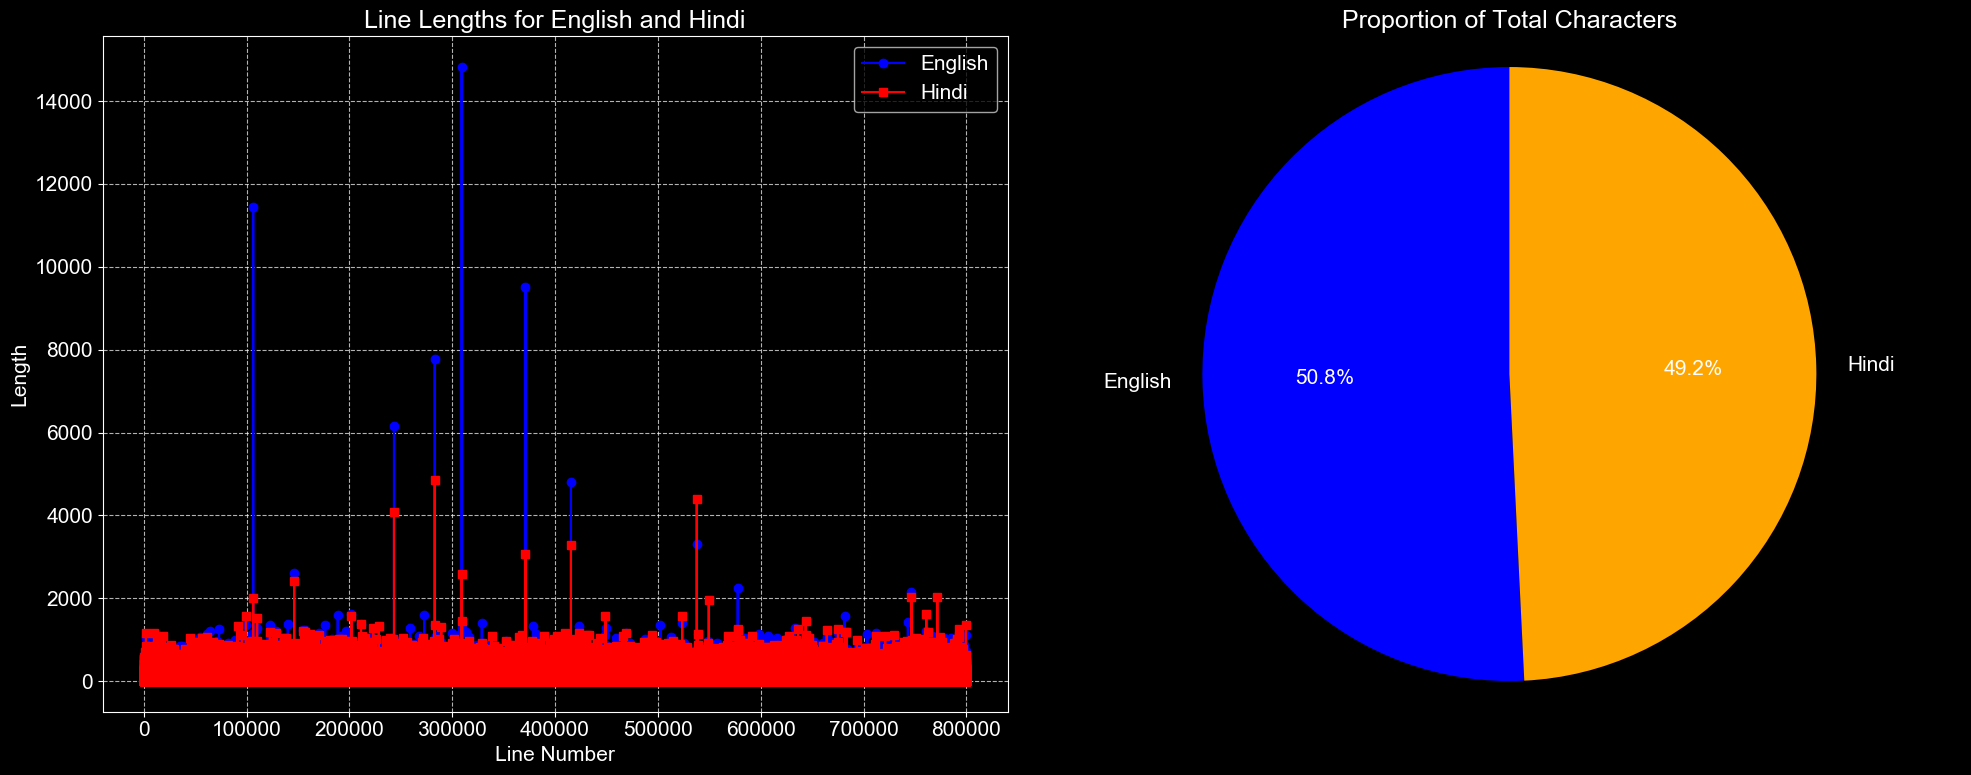

In [4]:

# Calculate lengths for each line in both languages
english_lengths = [len(x) for x in english_lines]
hindi_lengths = [len(y) for y in hindi_lines]

# Calculate total characters for each language
total_english_chars = sum(english_lengths)
total_hindi_chars = sum(hindi_lengths)

# Create the figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

# Line Plot
x_values = range(1, max(len(english_lines), len(hindi_lines)) + 1)

ax1.plot(x_values[:len(english_lengths)], english_lengths,
         marker='o', label='English', color='blue')
ax1.plot(x_values[:len(hindi_lengths)], hindi_lengths,
         marker='s', label='Hindi', color='red')

ax1.set_title('Line Lengths for English and Hindi')
ax1.set_xlabel('Line Number')
ax1.set_ylabel('Length')
ax1.legend()
ax1.grid(True, linestyle='--', alpha=0.7)

# Pie Chart
labels = 'English', 'Hindi'
sizes = [total_english_chars, total_hindi_chars]
colors = ['blue', 'orange']

ax2.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)
ax2.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle
ax2.set_title('Proportion of Total Characters')

# Adjust layout and display the plot


plt.tight_layout()
plt.show()




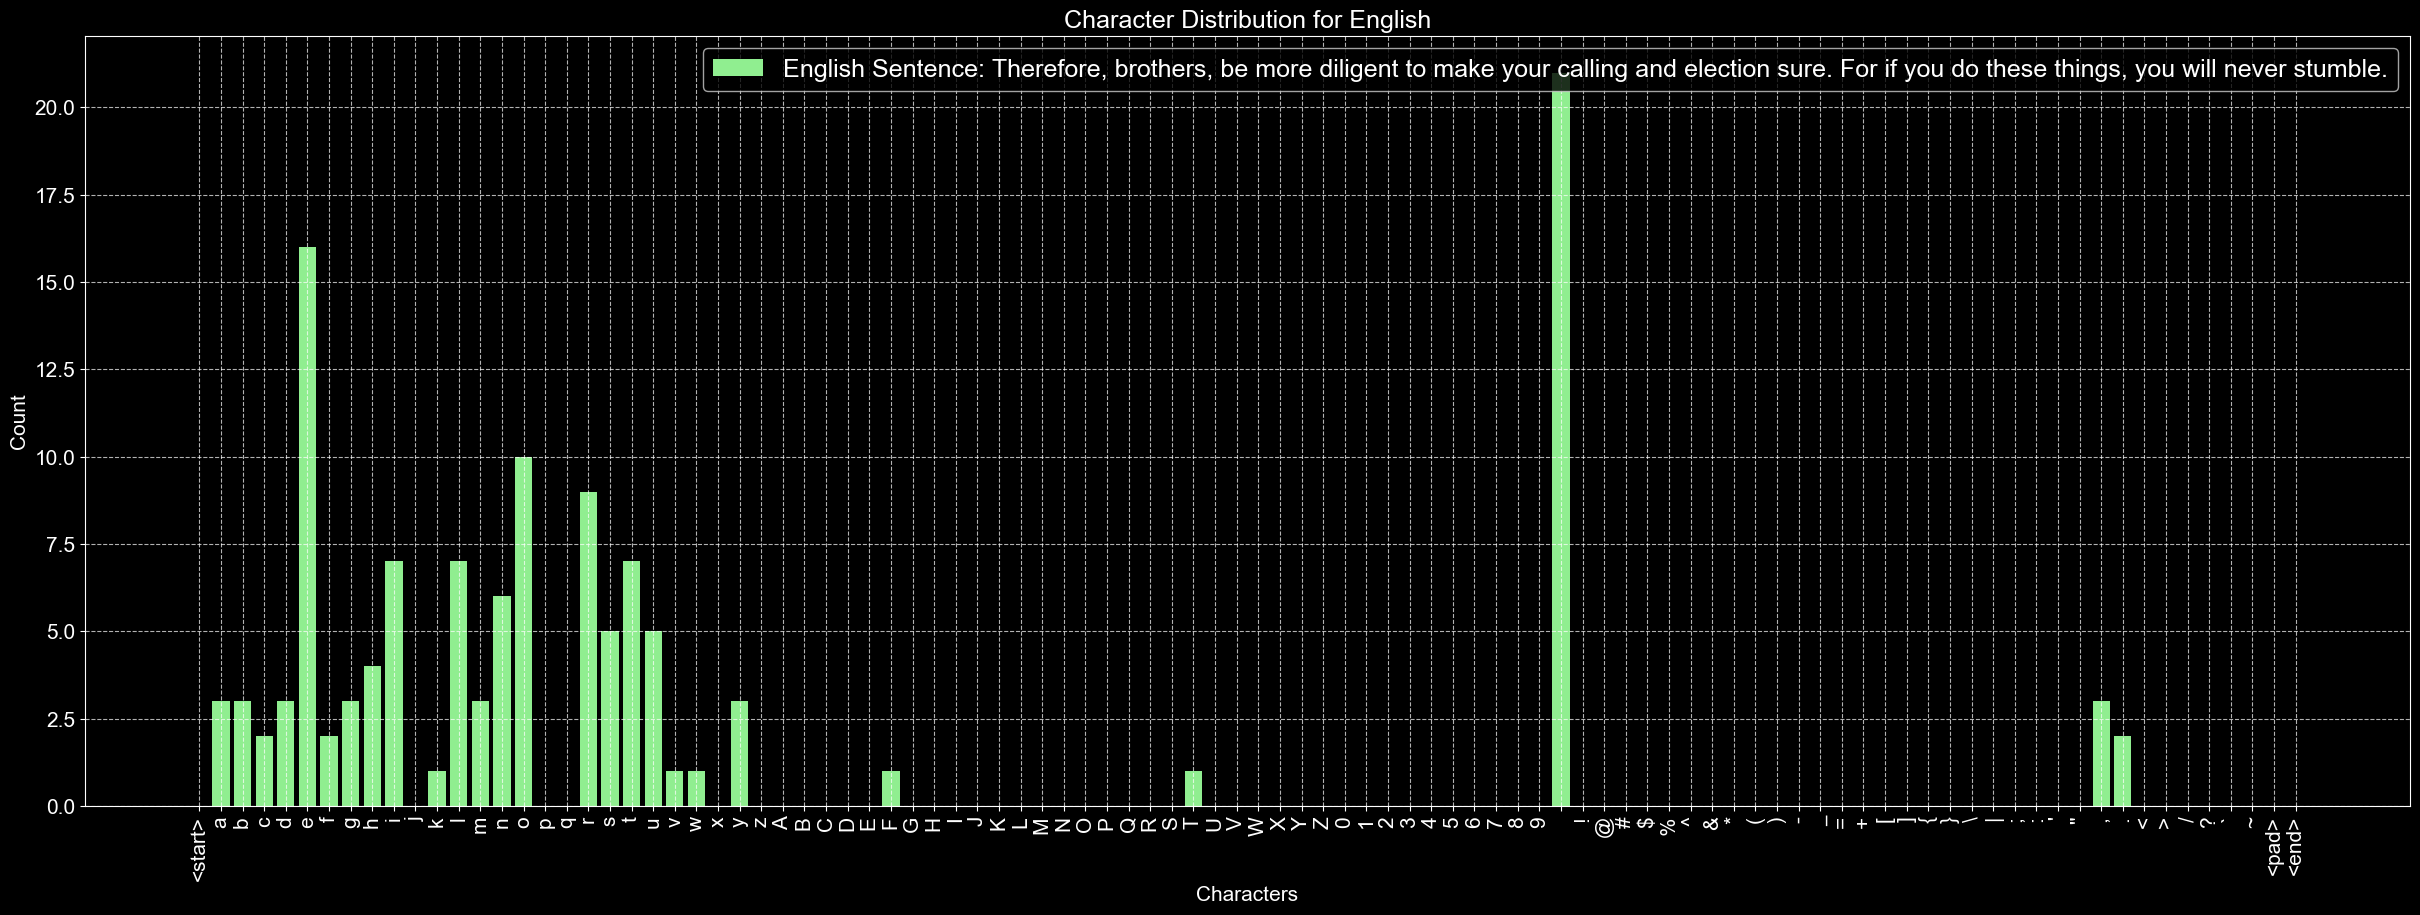

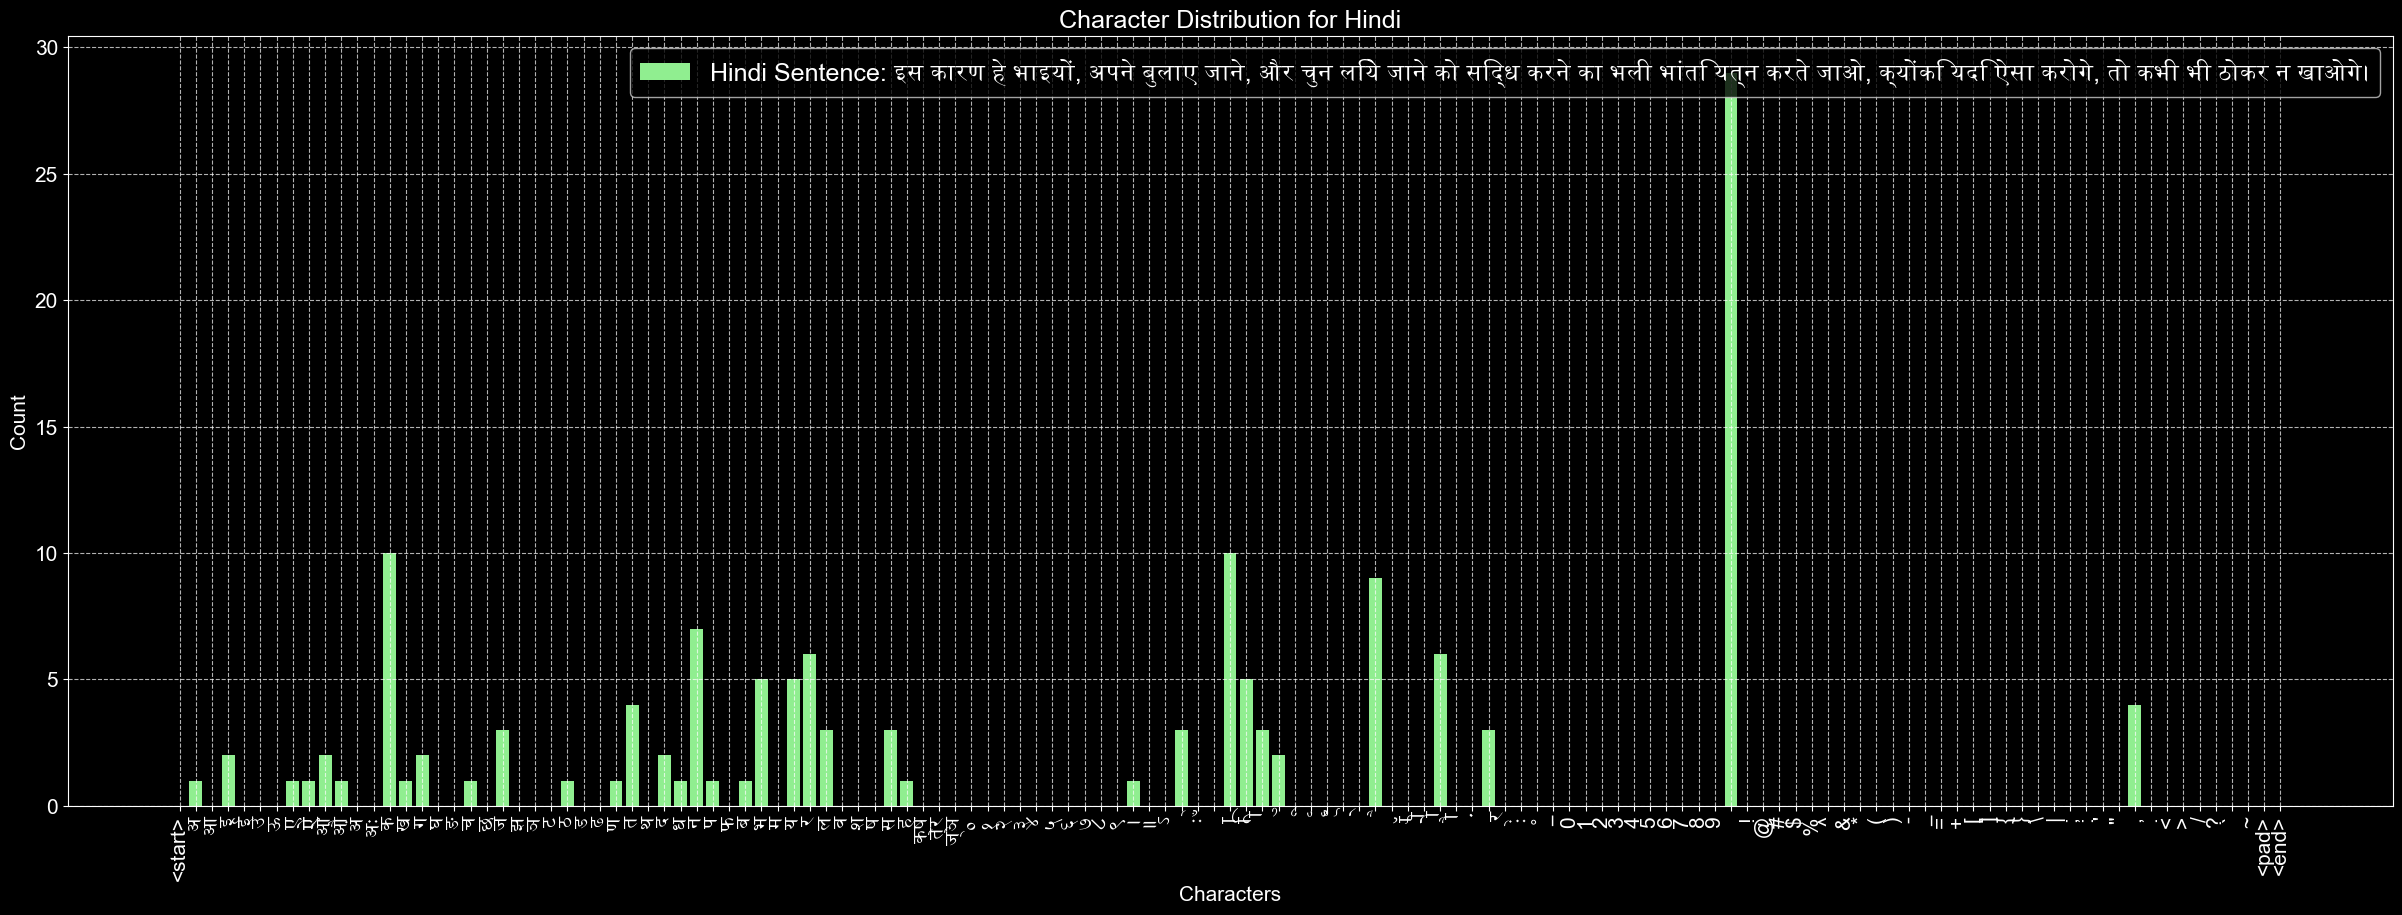

In [5]:
def plot_char_distribution(sentence: str, language: str):
    if language == 'english':
        vocabulary = english_vocabulary
    elif language == 'hindi':
        vocabulary = hind_vocabulary
    else:
        return "Invalid language. Choose either 'english' or 'hindi'."

    char_count = {char: 0 for char in vocabulary}
    for char in sentence:
        char_count[char] += 1

    x_values = range(len(vocabulary))
    y_values = [char_count[char] for char in vocabulary]

    plt.figure(figsize=(30, 10))
    plt.bar(x_values, y_values, color='lightgreen')
    plt.title(f'Character Distribution for {language.capitalize()}')
    plt.xlabel('Characters')
    plt.ylabel('Count')
    plt.xticks(x_values, vocabulary, rotation='vertical')
    legend_label = f'{language.capitalize()} Sentence: {sentence}'
    plt.legend([legend_label], loc='upper right', fontsize='large')

    plt.grid(True, linestyle='--', alpha=0.7)
    plt.show()


# Plotting the character distribution for the first sentence in each language
plot_char_distribution(english_lines[5], 'english')
plot_char_distribution(hindi_lines[5], 'hindi')

In [6]:
percentile_95 = np.percentile(english_lengths, 95)
print(f"95th Percentile for English: {percentile_95}")
percentile_95 = np.percentile(hindi_lengths, 95)
print(f"95th Percentile for Hindi: {percentile_95}")

95th Percentile for English: 232.0
95th Percentile for Hindi: 224.0


In [7]:
max_sequence_length = 200

def is_valid_tokens(sequence: str, language: str):
    if language == 'english':
        vocabulary = english_vocabulary
    elif language == 'hindi':
        vocabulary = hind_vocabulary
    else:
        return "Invalid language. Choose either 'english' or 'hindi'."

    for char in sequence:
        if char not in vocabulary:
            return False and f"Invalid character in {language} sentence: {char}"
    return True


def is_valid_length(sentence: str, max_sequent_length: int):
    return len(list(sentence)) < max_sequent_length-1


valid_sentences = [i for i in range(len(hindi_lines)) if is_valid_tokens(hindi_lines[i], 'hindi') and is_valid_tokens(english_lines[i], 'english') and is_valid_length(hindi_lines[i], max_sequence_length) and is_valid_length(english_lines[i], max_sequence_length)]
print(f"Number of total sentences: {len(hindi_lines)}")
print(f"Number of valid sentences: {len(valid_sentences)}")


Number of total sentences: 800000
Number of valid sentences: 591392


In [8]:
valid_sentences

[0,
 2,
 3,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 14,
 16,
 17,
 18,
 19,
 20,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 35,
 37,
 38,
 39,
 42,
 43,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 54,
 55,
 57,
 58,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 71,
 73,
 74,
 75,
 77,
 78,
 81,
 82,
 84,
 85,
 86,
 87,
 90,
 91,
 92,
 93,
 94,
 95,
 97,
 99,
 100,
 101,
 102,
 103,
 111,
 112,
 113,
 115,
 119,
 120,
 121,
 122,
 123,
 127,
 128,
 129,
 130,
 132,
 133,
 134,
 135,
 136,
 137,
 138,
 139,
 140,
 141,
 142,
 144,
 145,
 147,
 148,
 150,
 151,
 152,
 153,
 154,
 155,
 156,
 158,
 160,
 161,
 162,
 164,
 167,
 168,
 169,
 170,
 171,
 172,
 173,
 174,
 175,
 176,
 179,
 181,
 183,
 184,
 186,
 187,
 188,
 191,
 193,
 194,
 198,
 199,
 200,
 201,
 202,
 203,
 204,
 205,
 206,
 207,
 208,
 209,
 210,
 211,
 213,
 215,
 216,
 217,
 218,
 219,
 220,
 221,
 222,
 223,
 224,
 225,
 228,
 230,
 231,
 234,
 235,
 236,
 237,
 238,
 240,
 241,
 242,
 243,
 244,
 246,
 247,
 249,
 2

In [9]:
hindi_lines = [hindi_lines[i] for i in valid_sentences]
english_lines = [english_lines[i] for i in valid_sentences]

In [19]:
hindi_lines[:5]

['जिसके जवाब में पाक ने अच्छी शुरुआत की थी.',
 'कांग्रेस नेता तमिलनाडु से शिवगंगा लोकसभा क्षेत्र का प्रतिनिधित्व करते हैं.',
 'संबंधन प्रयास के बारे में उपयोक्ता को प्रांप्ट करें',
 'इस कारण हे भाइयों, अपने बुलाए जाने, और चुन लिये जाने को सिद्ध करने का भली भांति यत्न करते जाओ, क्योंकि यदि ऐसा करोगे, तो कभी भी ठोकर न खाओगे।',
 'समिति में जिला एवं सत्र न्यायाधीश, कलेक्टर, पुलिस अधीक्षक व जिला विधिक सेवा प्राधिकरण के सचिव शामिल रहते हैं।']

## DatasetLoader

In [10]:
class languageDataset(Dataset):
    def __init__(self, hindi_sentences, english_sentences):
        self.hindi_sentences = hindi_sentences
        self.english_sentences = english_sentences

    def __len__(self):
        return len(self.hindi_sentences)

    def __getitem__(self, idx):
        hindi_sentence = self.hindi_sentences[idx]
        english_sentence = self.english_sentences[idx]
        return english_sentence[idx], hindi_sentence [idx]


dataset=languageDataset(hindi_lines,english_lines)
print(dataset[5])

('Police is present on the spot.', 'पुलिस मौके पर मौजूद है।')


In [11]:
batch_size = 30
dataloader = DataLoader(dataset, batch_size=batch_size)

for i, batch_data in enumerate(iter(dataloader)):
    print(f"{batch_data}")
    if i >30:
        break

[('In reply, Pakistan got off to a solid start.', 'The Congress leader represents Sivaganga Lok Sabha segment from Tamil Nadu.', 'Prompt the user about connection attempts', 'Therefore, brothers, be more diligent to make your calling and election sure. For if you do these things, you will never stumble.', 'The review committee meeting chaired by the District Judges will be attended by Collectors, SPs, Superintendents of jails and Secretary of District Legal Services Authority.', 'Police is present on the spot.', 'Prime Minister Narendra Modi is slated to campaign for BJP in second phase of Assembly elections in Udhampur and Poonch district of Jammu and Kashmir tomorrow', 'It has a battery backup of 3050mAh.', '"Similarly, Babu Raghuvansh Prasad Singh ji also worked for poor,"" he said in his address."', 'All 176 passengers died in the incident.', 'I will ask the same question again.', 'Not invited', 'Sunny Leone plays a paranormal expert in the series.', 'Then after it becomes dry, rin

In [12]:
def tokenize(sentence, language_to_index, start_token=True, end_token=True):
    sentence_word_indices = [language_to_index[token] for token in list(sentence)]
    if start_token:
        sentence_word_indices.insert(0, language_to_index[START_TOKEN])
    if end_token:
        sentence_word_indices.append(language_to_index[END_TOKEN])

    for _ in range(len(sentence_word_indices), max_sequence_length):
        sentence_word_indices.append(language_to_index[PAD_TOKEN])
    return tensor(sentence_word_indices)



In [13]:
batch_data[0]

('In the broad sweep of history, the changing world is not necessarily a new situation',
 'Best wishes for your bright future.',
 'If you have these questions in your mind, here we have the answer for you.',
 'He is also working on three Hindi films.',
 'Let Israel hope in the LORD: for with the LORD there is mercy, and with him is plenteous redemption.',
 'Jammu and Kashmir Governor NN Vohra.',
 'The martyrs mother Mrs Sudha Sharma and brother, Piyush Sharma who also reside in Jaipur',
 'The mother too had demanded a CBI inquiry.',
 'Annual prize distribution function held',
 'The police, however, arrested the accused.',
 'Normal life was thrown out of gear in Karnataka where the Congress-JD-S combine is in power.',
 'Subsequently, they sexually assaulted him.',
 'He also asked them to showcase and constantly celebrate the contributions of the local heroes like police officers, doctors, nurses, ward boys etc.at national level.',
 'The Gurgaon police said that a case had been registere

In [14]:
EN_tokenized=[]
HI_tokenized=[]
for i in range(batch_size):
    EN_tokenized.append(tokenize(batch_data[0][i],english_to_index,start_token=False,end_token=False))
    HI_tokenized.append(tokenize(batch_data[1][i],hindi_to_index,start_token=True,end_token=True))

EN_tokenized=stack(EN_tokenized)
HI_tokenized=stack(HI_tokenized)


In [15]:
# print the whole tensor
print(HI_tokenized)

tensor([[  0,   3,  28,  66,  45,  65,  44,  96,  13,  74,  96,  41,  62,  38,
          65,  33,  13,  96,  33,  39,  66,  30,  70,  42,  62,  38,  96,  37,
          74,  81,  96,  35,  30,  40,  28,  67,  96,  30,  68,  32,  66,  38,
          65,  96,  13,  78,   4,  96,  32,   4,  96,  44,  62,  29,  66,  28,
          66,  96,  32,  45,  67,  81,  96,  45,  75, 130, 129, 129, 129, 129,
         129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129,
         129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129,
         129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129,
         129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129,
         129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129,
         129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129,
         129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129,
         129, 129, 129, 129, 129, 129, 129, 129, 129

In [16]:
NEG_INFTY = -1e9

def create_masks(eng_batch, hin_batch):
    num_sentences = len(eng_batch)
    look_ahead_mask = full([max_sequence_length, max_sequence_length] , True)
    look_ahead_mask = triu(look_ahead_mask, diagonal=1)
    encoder_padding_mask = full([num_sentences, max_sequence_length, max_sequence_length] , False)
    decoder_padding_mask_self_attention = full([num_sentences, max_sequence_length, max_sequence_length] , False)
    decoder_padding_mask_cross_attention = full([num_sentences, max_sequence_length, max_sequence_length] , False)

    for idx in range(num_sentences):
      eng_sentence_length, hin_sentence_length = len(eng_batch[idx]), len(hin_batch[idx]) # get the length of the sentence
      eng_chars_to_padding_mask = np.arange(eng_sentence_length + 1, max_sequence_length) # get the indices of the characters to be masked after the sentence
      hin_chars_to_padding_mask = np.arange(hin_sentence_length + 1, max_sequence_length) # get the indices of the characters to be masked after the sentence
      encoder_padding_mask[idx, :, eng_chars_to_padding_mask] = True # mask the characters after the sentence
      encoder_padding_mask[idx, eng_chars_to_padding_mask, :] = True # mask the characters before the sentence
      decoder_padding_mask_self_attention[idx, :, hin_chars_to_padding_mask] = True # mask the characters after the sentence (for self-attention or look-ahead mask)
      decoder_padding_mask_self_attention[idx, hin_chars_to_padding_mask, :] = True # mask the characters before the sentence (for self-attention or look-ahead mask)
      decoder_padding_mask_cross_attention[idx, :, eng_chars_to_padding_mask] = True # mask the characters after the sentence (for cross-attention or padding mask)
      decoder_padding_mask_cross_attention[idx, hin_chars_to_padding_mask, :] = True # mask the characters before the sentence (for cross-attention or padding mask)

    encoder_self_attention_mask = where(encoder_padding_mask, NEG_INFTY, 0)
    decoder_self_attention_mask = where(look_ahead_mask + decoder_padding_mask_self_attention, NEG_INFTY, 0)
    decoder_cross_attention_mask = where(decoder_padding_mask_cross_attention, NEG_INFTY, 0)
    # print(f"encoder_self_attention_mask {encoder_self_attention_mask.size()}: {encoder_self_attention_mask[0, :10, :10]}")
    # print(f"decoder_self_attention_mask {decoder_self_attention_mask.size()}: {decoder_self_attention_mask[0, :10, :10]}")
    # print(f"decoder_cross_attention_mask {decoder_cross_attention_mask.size()}: {decoder_cross_attention_mask[0, :10, :10]}")
    return encoder_self_attention_mask, decoder_self_attention_mask, decoder_cross_attention_mask
        


create_masks(batch_data[0], batch_data[1])

(tensor([[[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ..., -1.0000e+09,
           -1.0000e+09, -1.0000e+09],
          [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ..., -1.0000e+09,
           -1.0000e+09, -1.0000e+09],
          [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ..., -1.0000e+09,
           -1.0000e+09, -1.0000e+09],
          ...,
          [-1.0000e+09, -1.0000e+09, -1.0000e+09,  ..., -1.0000e+09,
           -1.0000e+09, -1.0000e+09],
          [-1.0000e+09, -1.0000e+09, -1.0000e+09,  ..., -1.0000e+09,
           -1.0000e+09, -1.0000e+09],
          [-1.0000e+09, -1.0000e+09, -1.0000e+09,  ..., -1.0000e+09,
           -1.0000e+09, -1.0000e+09]],
 
         [[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ..., -1.0000e+09,
           -1.0000e+09, -1.0000e+09],
          [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ..., -1.0000e+09,
           -1.0000e+09, -1.0000e+09],
          [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ..., -1.0000e+09,
           -1.0000e+09, -1.0000e+09],
          ...,
    

In [17]:
# start training
import torch
from transformer_temp import Transformer

d_model = 512
batch_size = 30
ffn_hidden = 2048
num_heads = 8
drop_prob = 0.1
num_layers = 6
max_sequence_length = 200
kn_vocab_size = len(hind_vocabulary)

transformer = Transformer(d_model, 
                          ffn_hidden,
                          num_heads, 
                          drop_prob, 
                          num_layers, 
                          max_sequence_length,
                          kn_vocab_size,
                          english_to_index,
                          hind_vocabulary,
                          START_TOKEN, 
                          END_TOKEN, 
                          PAD_TOKEN)



In [18]:
from torch import nn
from tqdm import tqdm
criterian = nn.CrossEntropyLoss(ignore_index=hindi_to_index[PAD_TOKEN],
                                reduction='none')

# When computing the loss, we are ignoring cases when the label is the padding token
for params in transformer.parameters():
    if params.dim() > 1:
        nn.init.xavier_uniform_(params)

optimizer = torch.optim.Adam(transformer.parameters(), lr=1e-4)
device = torch.device('mps') 


transformer.train()
transformer.to(device)
total_loss=0
epochs=100
iterator=iter(dataloader)

for epoch in range(epochs):
    print(f"Epoch {epoch}")
    
    for batch_num, batch in enumerate(tqdm(iterator)):
        transformer.train()
        eng_batch, hi_batch = batch
       


        encoder_self_attention_mask, decoder_self_attention_mask, decoder_cross_attention_mask = create_masks(eng_batch, hi_batch)
        optimizer.zero_grad()
        hi_predictions = transformer(eng_batch,
                                     hi_batch,
                                     encoder_self_attention_mask.to(device), 
                                     decoder_self_attention_mask.to(device), 
                                     decoder_cross_attention_mask.to(device),
                                     enc_start_token=False,
                                     enc_end_token=False,
                                     dec_start_token=True,
                                     dec_end_token=False
                                     )
        # labels = transformer.decoder.sentence_embedding.batch_tokenize(hi_batch, start_token=False, end_token=True)
        # loss = criterian(
        #     hi_predictions.view(-1, kn_vocab_size).to(device),
        #     labels.view(-1).to(device)
        # ).to(device)
        # valid_indicies = torch.where(labels.view(-1) == hindi_to_index[PAD_TOKEN], False, True)
        # loss = loss.sum() / valid_indicies.sum()
        # loss.backward()
        # optimizer.step()
        # #train_losses.append(loss.item())
        # if batch_num % 100 == 0:
        #     print(f"Iteration {batch_num} : {loss.item()}")
        #     print(f"English: {eng_batch[0]}")
        #     print(f"Hindi Translation: {hi_batch[0]}")
        #     kn_sentence_predicted = torch.argmax(hi_predictions[0], axis=1)
        #     predicted_sentence = ""
        #     for idx in kn_sentence_predicted:
        #       if idx == hindi_to_index[END_TOKEN]:
        #         break
        #       predicted_sentence += index_to_hindi[idx.item()]
        #     print(f"Kannada Prediction: {predicted_sentence}")


        #     transformer.eval()
        #     hi_sentence = ("",)
        #     eng_sentence = ("should we go to the mall?",)
        #     for word_counter in range(max_sequence_length):
        #         encoder_self_attention_mask, decoder_self_attention_mask, decoder_cross_attention_mask= create_masks(eng_sentence, hi_sentence)
        #         predictions = transformer(eng_sentence,
        #                                   hi_sentence,
        #                                   encoder_self_attention_mask.to(device), 
        #                                   decoder_self_attention_mask.to(device), 
        #                                   decoder_cross_attention_mask.to(device),
        #                                   enc_start_token=False,
        #                                   enc_end_token=False,
        #                                   dec_start_token=True,
        #                                   dec_end_token=False)
        #         next_token_prob_distribution = predictions[0][word_counter] # not actual probs
        #         next_token_index = torch.argmax(next_token_prob_distribution).item()
        #         next_token = index_to_hindi[next_token_index]
        #         hi_sentence = (hi_sentence[0] + next_token, )
        #         if next_token == END_TOKEN:
        #           break
            
        #     print(f"Evaluation translation (should we go to the mall?) : {hi_sentence}")
        #     print("-------------------------------------------")

Epoch 0


  0%|          | 0/19714 [00:01<?, ?it/s]


TypeError: list indices must be integers or slices, not str